In [1]:
# Cell 0 — bootstrap (imports, paths, config, helpers)
import os, sys, json, math, random, subprocess, importlib
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

# Optional, but handy
try:
    import skimage
    from skimage.draw import polygon as sk_polygon
except:
    subprocess.check_call([sys.executable, "-m", "pip", "install", "--quiet", "scikit-image"])
    from skimage.draw import polygon as sk_polygon

# ----------------- USER PATHS -----------------
DATA_ROOT = Path(r"C:\Users\DELL\OpenPCDet\data\kitti\training")  # KITTI training root (has velodyne, label_2, calib)
OUT_BASE  = Path(r"D:\Data\essentials\Thapar\MTech\Projects\Main proj\bev_npu_outputs\new_outputs")
OUT_BASE.mkdir(parents=True, exist_ok=True)

# auto run folder (simple integer series)
def next_run_dir(base: Path) -> Path:
    nums = [int(p.name.replace("run_","")) for p in base.glob("run_*") if p.name.replace("run_","").isdigit()]
    n = 1 if not nums else max(nums)+1
    rd = base / f"run_{n}"
    rd.mkdir(parents=True, exist_ok=True)
    return rd

RUN_DIR = next_run_dir(OUT_BASE)
print("RUN_DIR:", RUN_DIR)

# subfolders
for d in ["bev_float","bev_u8","golden","explore","lists"]:
    (RUN_DIR/d).mkdir(exist_ok=True)

# ----------------- BEV CONFIG -----------------
cfg = {
    "x_range": (0.0, 70.0),     # forward (meters)
    "y_range": (-40.0, 40.0),   # left/right
    "z_range": (-3.0,  2.0),    # up
    "res": 0.25,                # meters per pixel
    "q": {
        "count_cap": 8.0,       # occupancy cap for uint8 mapping
        "zvar_cap":  2.0        # z variance cap
    }
}
xr, yr, zr = cfg["x_range"], cfg["y_range"], cfg["z_range"]
H = int(round((xr[1]-xr[0]) / cfg["res"])) + 1
W = int(round((yr[1]-yr[0]) / cfg["res"])) + 1
cfg["H"], cfg["W"] = H, W
print("Grid:", H, "x", W)

np.set_printoptions(precision=3, suppress=True)
random.seed(42); np.random.seed(42)


RUN_DIR: D:\Data\essentials\Thapar\MTech\Projects\Main proj\bev_npu_outputs\new_outputs\run_11
Grid: 281 x 321


In [2]:
# Cell 1 — discover frames, split, save lists
VELO = (DATA_ROOT / "velodyne")
LAB2 = (DATA_ROOT / "label_2")
CALB = (DATA_ROOT / "calib")

vids = set(p.stem for p in VELO.glob("*.bin"))
lids = set(p.stem for p in LAB2.glob("*.txt"))
cids = set(p.stem for p in CALB.glob("*.txt"))
IDs  = sorted(list(vids & lids & cids))
print("Found frames:", len(IDs))

# split 80/10/10
random.shuffle(IDs)
n = len(IDs)
train_ids = sorted(IDs[:int(0.8*n)])
val_ids   = sorted(IDs[int(0.8*n):int(0.9*n)])
test_ids  = sorted(IDs[int(0.9*n):])

def save_list(name, arr):
    with open(RUN_DIR/"lists"/f"{name}.txt","w") as f: f.write("\n".join(arr))

save_list("train", train_ids)
save_list("val",   val_ids)
save_list("test",  test_ids)
print("Splits:", len(train_ids), len(val_ids), len(test_ids))


Found frames: 7481
Splits: 5984 748 749


In [3]:
# Cell 2 — BEV core + HAG
def load_points_bin(path: Path) -> np.ndarray:
    arr = np.fromfile(path, dtype=np.float32).reshape(-1, 4)
    return arr  # (x, y, z, intensity), KITTI velodyne

def bev_from_points(points: np.ndarray, cfg: dict):
    x, y, z, i = points.T
    xr, yr, zr = cfg["x_range"], cfg["y_range"], cfg["z_range"]
    H, W = cfg["H"], cfg["W"]

    # ROI filter
    m = (x>=xr[0])&(x<=xr[1])&(y>=yr[0])&(y<=yr[1])&(z>=zr[0])&(z<=zr[1])
    x, y, z, i = x[m], y[m], z[m], i[m]

    # meter -> grid index
    rscale = (H-1)/(xr[1]-xr[0]); cscale = (W-1)/(yr[1]-yr[0])
    iy = np.floor((x - xr[0]) * rscale).astype(np.int32)
    ix = np.floor((y - yr[0]) * cscale).astype(np.int32)
    lin = iy * W + ix

    # reductions
    count = np.bincount(lin, minlength=H*W).astype(np.float32).reshape(H, W)
    sumz  = np.bincount(lin, weights=z,   minlength=H*W).reshape(H, W)
    sumz2 = np.bincount(lin, weights=z*z, minlength=H*W).reshape(H, W)
    sumi  = np.bincount(lin, weights=i,   minlength=H*W).reshape(H, W)

    zmax = np.full(H*W, -1e9, dtype=np.float32); np.maximum.at(zmax, lin, z); zmax = zmax.reshape(H,W)
    eps = 1e-6
    zmean = sumz / np.maximum(count, eps)
    imean = sumi / np.maximum(count, eps)
    zvar  = (sumz2 / np.maximum(count, eps)) - zmean**2
    zvar  = np.clip(zvar, 0.0, None)

    # simple ground estimate per row (x): 10th percentile of z where count>0, then smooth
    ground = np.full((H,), np.nan, dtype=np.float32)
    for r in range(H):
        colz = z[ iy==r ] if len(z)>0 else np.array([])
        if colz.size>20:
            ground[r] = np.percentile(colz, 10)
    # fill NaNs by nearest valid
    if np.isnan(ground).any():
        valid = ~np.isnan(ground)
        if valid.any():
            ground = np.interp(np.arange(H), np.where(valid)[0], ground[valid])
        else:
            ground[:] = zr[0]
    # broadcast to (H,W)
    ground_map = np.repeat(ground[:,None], W, axis=1)
    hag_max = np.clip(zmax - ground_map, 0.0, zr[1]-zr[0])  # height-above-ground of tallest return

    bev = np.stack([count, zmax, zmean, imean, zvar, hag_max], axis=0)  # [6,H,W]
    return bev

def quantize_bev_u8(bev: np.ndarray, cfg: dict) -> np.ndarray:
    # Map to 8-bit per channel for quick viz or INT8 export
    zr = cfg["z_range"]; q = cfg["q"]
    count = np.clip((bev[0]/q["count_cap"])*255, 0, 255)
    z_to_u8 = lambda arr: np.clip((arr - zr[0])/(zr[1]-zr[0])*255, 0, 255)
    zmax  = z_to_u8(bev[1])
    zmean = z_to_u8(bev[2])
    imean = np.clip(bev[3]*255, 0, 255)
    zvar  = np.clip((bev[4]/q["zvar_cap"])*255, 0, 255)
    # HAG upper-bounded by (zr[1]-zr[0])
    hag_u8 = np.clip((bev[5]/(zr[1]-zr[0]))*255, 0, 255)
    return np.stack([count, zmax, zmean, imean, zvar, hag_u8], axis=0).astype(np.uint8)


In [4]:
# Cell 3 — calib/labels → golden mask (vehicles)
def read_calib(fid: str):
    with open(CALB/f"{fid}.txt") as f:
        lines = [ln.strip() for ln in f if ln.strip()]
    kv = {}
    for ln in lines:
        if ":" not in ln: continue
        k, v = ln.split(":",1)
        kv[k] = np.fromstring(v, sep=" ")
    R0_rect = kv["R0_rect"].reshape(3,3)
    Tr_v2c  = kv["Tr_velo_to_cam"].reshape(3,4)
    # build 4x4
    Rext = np.eye(4, dtype=np.float32); Rext[:3,:3] = R0_rect
    Text = np.eye(4, dtype=np.float32); Text[:3,:4] = Tr_v2c
    T_v2r = Rext @ Text           # velo -> rect
    T_r2v = np.linalg.inv(T_v2r)  # rect -> velo
    return T_r2v

VEH_CLASSES = {"Car","Van","Truck","Tram"}  # 2-class problem: vehicle vs background

def parse_label2(fid: str):
    out = []
    with open(LAB2/f"{fid}.txt") as f:
        for ln in f:
            ln = ln.strip()
            if not ln: continue
            parts = ln.split()
            cls = parts[0]
            if cls not in VEH_CLASSES: continue
            # fields: cls, trunc, occ, alpha, bbox(4), dims(h,w,l), loc(x,y,z), ry
            vals = list(map(float, parts[1:]))
            h,w,l = vals[7], vals[8], vals[9]
            x,y,z = vals[10], vals[11], vals[12]
            ry    = vals[13]
            out.append((h,w,l,x,y,z,ry))
    return out

def kitti_box_corners(h,w,l,x,y,z,ry):
    # object frame corners in rect camera (y down)
    x_c = np.array([ l/2,  l/2, -l/2, -l/2,  l/2,  l/2, -l/2, -l/2 ])
    y_c = np.array([   0,    0,    0,    0,  -h,  -h,   -h,   -h ])
    z_c = np.array([ w/2, -w/2, -w/2,  w/2, w/2, -w/2, -w/2,  w/2 ])
    # rotate around y
    c, s = math.cos(ry), math.sin(ry)
    R = np.array([[ c, 0, s],
                  [ 0, 1, 0],
                  [-s, 0, c]])
    P = R @ np.vstack([x_c, y_c, z_c])
    P[0,:] += x; P[1,:] += y; P[2,:] += z
    return P  # (3,8) in rect camera

def golden_mask_for_frame(fid: str, cfg: dict):
    H,W = cfg["H"], cfg["W"]
    xr,yr = cfg["x_range"], cfg["y_range"]
    rscale = (H-1)/(xr[1]-xr[0]); cscale = (W-1)/(yr[1]-yr[0])

    T_r2v = read_calib(fid)
    boxes = parse_label2(fid)

    mask = np.zeros((H,W), dtype=np.uint8)
    for (h,w,l,x,y,z,ry) in boxes:
        C = kitti_box_corners(h,w,l,x,y,z,ry)   # rect cam
        C_h = np.vstack([C, np.ones((1,8))])    # 4x8
        V = (T_r2v @ C_h)[:3,:]                # velodyne
        # bottom face indices: 4..7 in our convention
        xb, yb, zb = V[0,4:], V[1,4:], V[2,4:]
        # discard boxes outside ROI
        if (xb.max()<xr[0]) or (xb.min()>xr[1]) or (yb.max()<yr[0]) or (yb.min()>yr[1]): 
            continue
        # to pixel coords
        iy = np.clip(np.floor((xb - xr[0]) * rscale).astype(np.int32), 0, H-1)
        ix = np.clip(np.floor((yb - yr[0]) * cscale).astype(np.int32), 0, W-1)
        rr, cc = sk_polygon(iy, ix, shape=(H,W))
        mask[rr, cc] = 1
    return mask


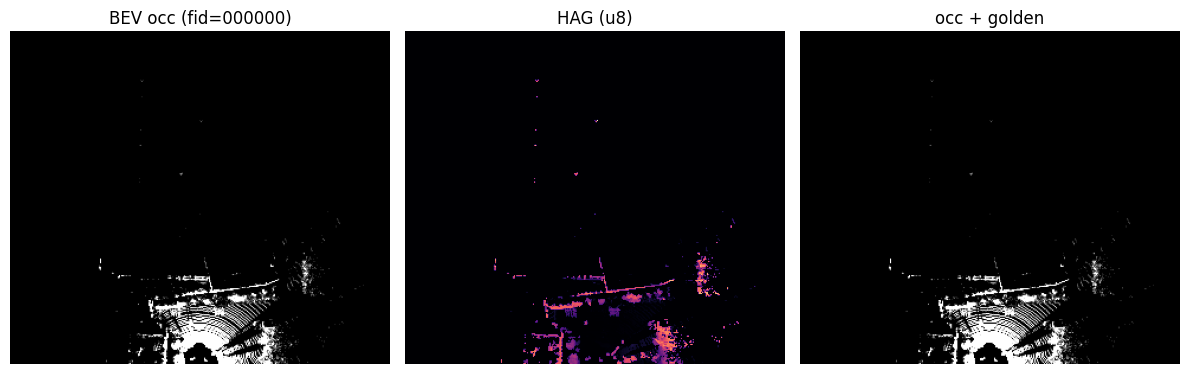

In [5]:
# Cell 4 — quick single-frame sanity
fid = train_ids[0]  # change if you like
pts = load_points_bin(VELO/f"{fid}.bin")
bev = bev_from_points(pts, cfg)
bev_u8 = quantize_bev_u8(bev, cfg)
g = golden_mask_for_frame(fid, cfg)

plt.figure(figsize=(12,4))
plt.subplot(131); plt.title(f"BEV occ (fid={fid})"); plt.imshow(bev_u8[0], origin='lower', cmap='gray'); plt.axis('off')
plt.subplot(132); plt.title("HAG (u8)");           plt.imshow(bev_u8[5], origin='lower', cmap='magma'); plt.axis('off')
ov = np.dstack([bev_u8[0], bev_u8[0], bev_u8[0]]).astype(np.float32)
ov[g==1, 1] = 255  # green overlay for golden
plt.subplot(133); plt.title("occ + golden"); plt.imshow(ov.astype(np.uint8), origin='lower'); plt.axis('off')
plt.tight_layout(); plt.show()


In [44]:
# Cell 5 — batch export BEV & GOLDEN for exploration
SAMPLE = train_ids[:2000]  # start small; you can go full later

for fid in tqdm(SAMPLE, desc="export"):
    pts = load_points_bin(VELO/f"{fid}.bin")
    bev = bev_from_points(pts, cfg)
    bev_u8 = quantize_bev_u8(bev, cfg)
    np.save(RUN_DIR/"bev_float"/f"{fid}.npy", bev)
    np.save(RUN_DIR/"bev_u8"/f"{fid}.npy",    bev_u8)
    g = golden_mask_for_frame(fid, cfg)
    np.save(RUN_DIR/"golden"/f"{fid}.npy", g)

print("done.")


export: 100%|██████████████████████████████████████████████████████████████████████| 2000/2000 [03:58<00:00,  8.38it/s]

done.


In [45]:
# --- Cell 5 (fix) — sanitize OCC/HAG and save normalized 2-ch features ---
import numpy as np, os
from pathlib import Path
from tqdm import tqdm

RUN_DIR  = Path(r"D:\Data\essentials\Thapar\MTech\Projects\Main proj\bev_npu_outputs\new_outputs\run_8")
SRC_DIR  = RUN_DIR / "bev_float"         # existing export (C,H,W) with [OCC, HAG_raw, ...]
DST_DIR  = RUN_DIR / "bev_2ch_norm"      # new, sanitized+normalized 2-ch (occ_norm, hag_norm)
DST_DIR.mkdir(exist_ok=True, parents=True)

# --- knobs ---
OCC_CLIP_MAX   = 4.0     # was 8.0 → make tighter
HAG_CLIP_MAX   = 2.5     # meters; cars ~1.5–2.2 high
OCC_EMPTY_THR  = 0.05    # below this, treat cell as empty (set HAG=0, optional: ignore in loss later)

src_files = sorted(SRC_DIR.glob("*.npy"))
assert src_files, f"No source npy in {SRC_DIR}"

for fp in tqdm(src_files, desc="sanitize"):
    X = np.load(fp)  # (C,H,W) expects [occ, hag_raw, ...]
    occ = X[0].astype(np.float32)

    # HAG raw (could be wrong sign/sentinel)
    if X.shape[0] >= 2:
        hag_raw = X[1].astype(np.float32)
    else:
        hag_raw = np.zeros_like(occ)

    # Fix sign: ground-issue heuristic
    # If median is negative → it was (ground - zmax). Flip so it becomes (zmax - ground).
    if np.nanmedian(hag_raw) < 0:
        hag = -hag_raw
    else:
        hag = hag_raw.copy()

    # Force empties to 0 height
    empty = occ < OCC_EMPTY_THR
    hag[empty] = 0.0

    # Clip & normalize
    occ_n = np.clip(occ, 0.0, OCC_CLIP_MAX) / OCC_CLIP_MAX
    hag   = np.clip(hag, 0.0, HAG_CLIP_MAX)
    hag_n = hag / HAG_CLIP_MAX

    X2 = np.stack([occ_n, hag_n], axis=0).astype(np.float32)
    np.save(DST_DIR / fp.name, X2)

print("✓ wrote 2-channel sanitized features to", DST_DIR)


sanitize: 100%|████████████████████████████████████████████████████████████████████| 2000/2000 [08:58<00:00,  3.72it/s]

✓ wrote 2-channel sanitized features to D:\Data\essentials\Thapar\MTech\Projects\Main proj\bev_npu_outputs\new_outputs\run_8\bev_2ch_norm


found 2000 frames with features+golden in bev_float & golden


gather (2000 fr): 100%|████████████████████████████████████████████████████████████| 2000/2000 [01:36<00:00, 20.70it/s]


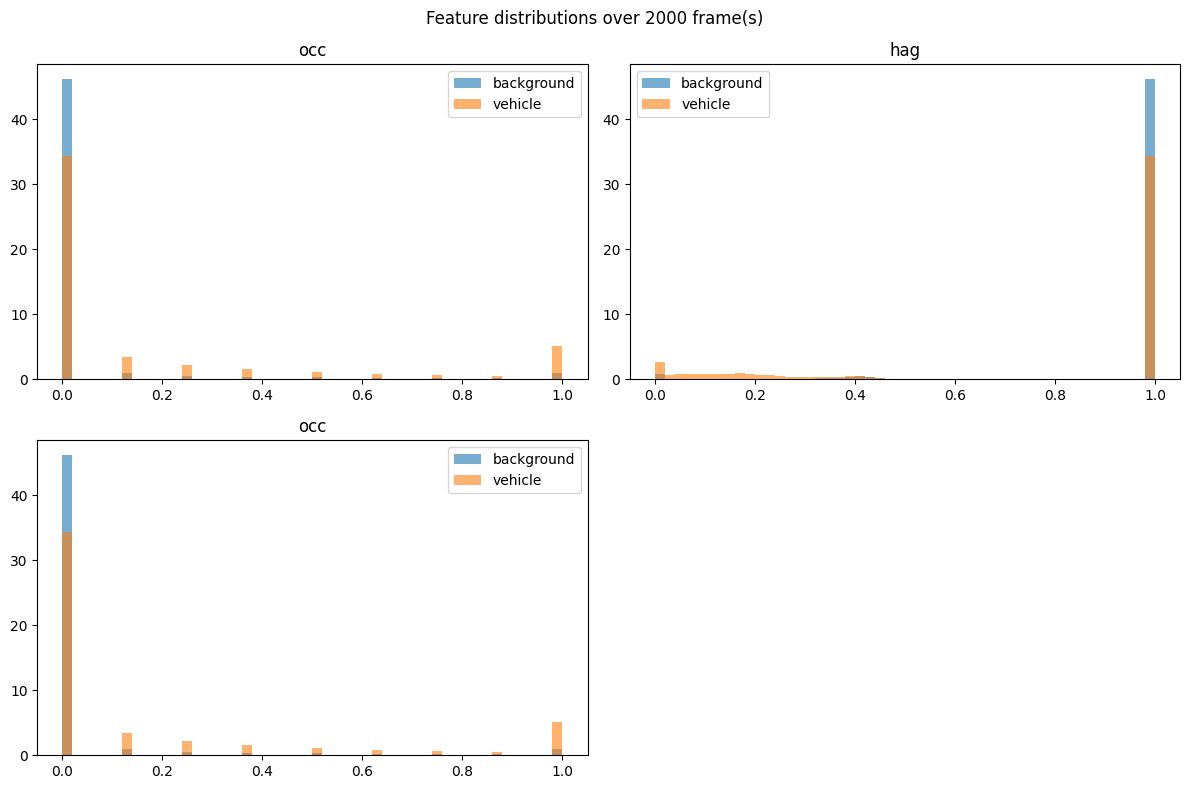

occ | pos mean=0.178 med=0.000  | neg mean=0.041 med=0.000
hag | pos mean=0.740 med=1.000  | neg mean=0.944 med=1.000
AUC[occ] = 0.517
AUC[hag] = 0.235


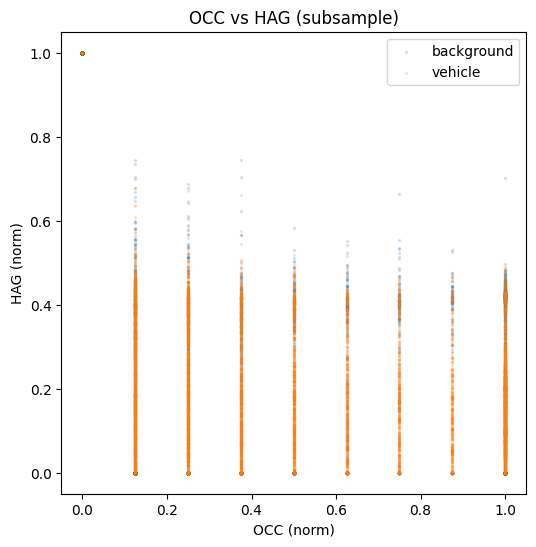

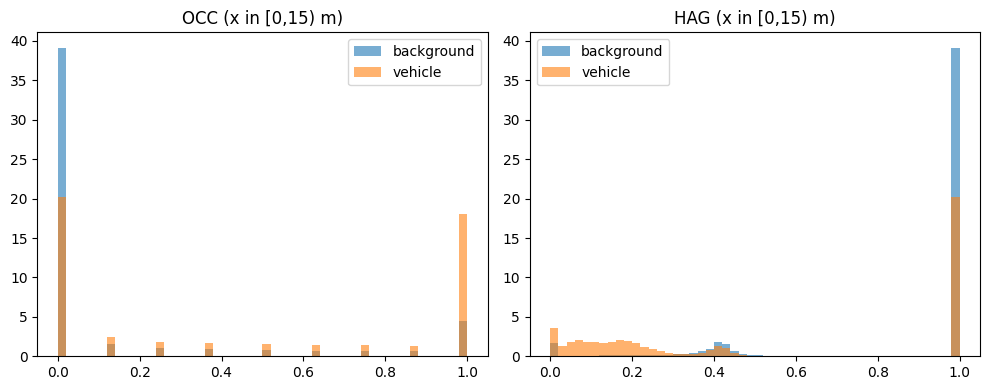

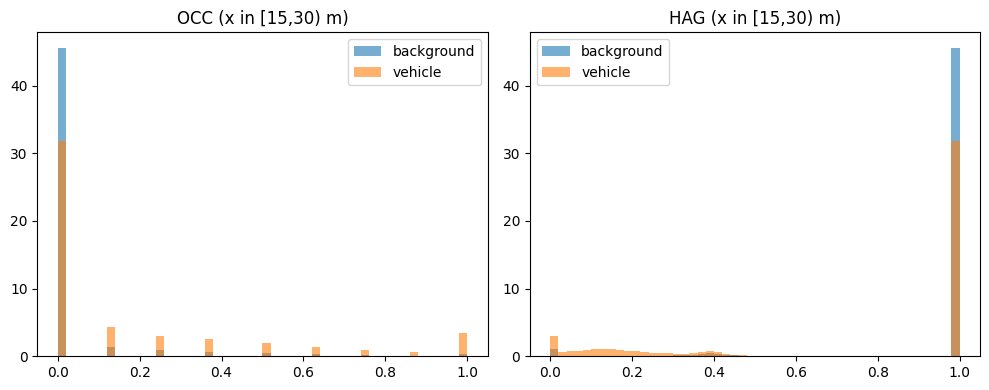

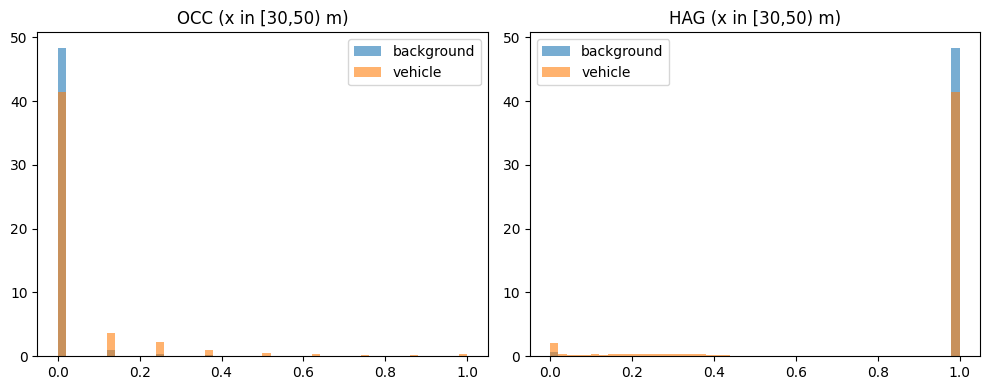

✅ Cell 6 complete: OCC/HAG normalized, AUCs, scatter, and distance-bucket histos ready.


In [47]:
# ===== Cell 6 — complete (OCC+HAG normalized) + extended exploration =====
import os, math, random, json, gc
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

# ---- paths (edit RUN_DIR if you made a new "run_*") ----
RUN_DIR   = Path(r"D:\Data\essentials\Thapar\MTech\Projects\Main proj\bev_npu_outputs\new_outputs\run_8")
FEAT_DIR  = RUN_DIR / "bev_float"   # per-frame float features saved by your Cell 5 (C,H,W) (OCC,HAG, ...)
MASK_DIR  = RUN_DIR / "golden"      # per-frame vehicle masks (H,W) where 1=vehicle

assert FEAT_DIR.exists(), f"Missing {FEAT_DIR}"
assert MASK_DIR.exists(), f"Missing {MASK_DIR}"

# ---- region-of-interest (needed for distance buckets). Change if different. ----
XRANGE = (0.0, 70.0)     # forward meters (min,max)
YRANGE = (-40.0, 40.0)   # left/right meters (min,max)

# ---- workload controls ----
N_FRAMES          = 3000        # how many frames to analyze (uses only frames that exist in both folders)
POS_PER_FRAME     = 2000        # positive pixels to sample per frame (cap; speeds up)
NEG_PER_FRAME     = 2000        # negative pixels to sample per frame (cap)
SCATTER_SAMPLES   = 60000       # total points for OCC vs HAG scatter (balanced pos/neg)
DIST_BUCKETS_M    = [(0,15), (15,30), (30,50)]  # near/mid/far in meters along +X

# ---- helpers ----
def list_ids(feat_dir, mask_dir):
    fx = {p.stem for p in feat_dir.glob("*.npy")}
    my = {p.stem for p in mask_dir.glob("*.npy")}
    both = sorted(fx & my)
    return both

def load_frame(fid):
    """Return (occ_norm, hag_norm, y, meta) where occ/hag in 0..1 and y in {0,1}."""
    X = np.load(FEAT_DIR / f"{fid}.npy")      # (C,H,W). Expect at least OCC,HAG channels.
    H, W = int(X.shape[1]), int(X.shape[2])
    y = np.load(MASK_DIR / f"{fid}.npy").astype(np.uint8)  # (H,W) 0/1

    occ = X[0]  # assume OCC is channel 0, as in your export
    hag_raw = X[1] if X.shape[0] >= 2 else np.zeros_like(occ)

    # --- make HAG positive in meters, robust to sign conventions ---
    # If median(HAG) < 0 we assume it was "ground - zmax" → flip sign.
    hag_pos = -hag_raw if np.nanmedian(hag_raw) < 0 else hag_raw
    hag_pos = np.clip(hag_pos, 0.0, 4.0)   # clamp to 0..~roof height

    # --- normalize channels to 0..1 ---
    occ_n = np.clip(occ, 0.0, 8.0) / 8.0   # OCC 0..8 → 0..1
    hag_n = hag_pos / 4.0                  # 0..4 m → 0..1

    meta = {"H": H, "W": W}
    return occ_n.astype(np.float32), hag_n.astype(np.float32), y, meta

def sample_pixels(occ, hag, y, pos_cap=POS_PER_FRAME, neg_cap=NEG_PER_FRAME):
    """Return sampled vectors for pos/neg: dict(channel->np.ndarray)."""
    H, W = y.shape
    pos_idx = np.flatnonzero(y > 0)
    neg_idx = np.flatnonzero(y == 0)

    if pos_idx.size > pos_cap:
        pos_idx = np.random.choice(pos_idx, size=pos_cap, replace=False)
    if neg_idx.size > neg_cap:
        neg_idx = np.random.choice(neg_idx, size=neg_cap, replace=False)

    P = {"occ": occ.ravel()[pos_idx], "hag": hag.ravel()[pos_idx]}
    N = {"occ": occ.ravel()[neg_idx], "hag": hag.ravel()[neg_idx]}
    return P, N

def try_import_sklearn_auc():
    try:
        from sklearn.metrics import roc_auc_score
        return roc_auc_score
    except Exception:
        return None

def simple_auc(scores, labels):
    """Numpy fallback AUC for binary labels (labels in {0,1})."""
    # sort by score descending
    order = np.argsort(-scores)
    y = labels[order]
    tp = np.cumsum(y)
    fp = np.cumsum(1 - y)
    tp = tp.astype(np.float64); fp = fp.astype(np.float64)
    tpr = tp / (tp[-1] if tp[-1] > 0 else 1.0)
    fpr = fp / (fp[-1] if fp[-1] > 0 else 1.0)
    # trapezoidal
    return np.trapz(tpr, fpr)

def occ_hag_scatter(P, N, max_points=SCATTER_SAMPLES):
    """Return subsampled arrays for scatter plot."""
    pos = np.vstack([P["occ"], P["hag"]]).T
    neg = np.vstack([N["occ"], N["hag"]]).T
    n_each = max_points // 2
    if pos.shape[0] > n_each:
        pos = pos[np.random.choice(pos.shape[0], n_each, replace=False)]
    if neg.shape[0] > n_each:
        neg = neg[np.random.choice(neg.shape[0], n_each, replace=False)]
    return pos, neg

def x_distance_grid(H):
    """Return per-row center distance in meters along +X given XRANGE and H."""
    x0, x1 = XRANGE
    dx = (x1 - x0) / H
    xs = x0 + (np.arange(H) + 0.5) * dx  # row centers
    return xs  # length H

def gather_distance_buckets(occ, hag, y):
    """Assign each pixel to a distance bucket by its row (X). Return dict per bucket."""
    H, W = y.shape
    xs = x_distance_grid(H)
    out = []
    for (a,b) in DIST_BUCKETS_M:
        rows = np.where((xs >= a) & (xs < b))[0]
        if rows.size == 0:
            out.append({"pos":{"occ":[], "hag":[]}, "neg":{"occ":[], "hag":[]}})
            continue
        m = np.isin(np.arange(H), rows)
        # Subsample to keep costs bounded
        pos_idx = np.flatnonzero((y>0) & m[:,None])
        neg_idx = np.flatnonzero((y==0) & m[:,None])
        if pos_idx.size > 4000: pos_idx = np.random.choice(pos_idx, 4000, False)
        if neg_idx.size > 4000: neg_idx = np.random.choice(neg_idx, 4000, False)
        out.append({
            "pos": {"occ": occ.ravel()[pos_idx], "hag": hag.ravel()[pos_idx]},
            "neg": {"occ": occ.ravel()[neg_idx], "hag": hag.ravel()[neg_idx]},
        })
    return out

# ---- main collection loop ----
all_ids = list_ids(FEAT_DIR, MASK_DIR)
if not all_ids:
    raise SystemExit("No frames with both features+golden found. Run your export and golden cells first.")

ids = all_ids[:min(N_FRAMES, len(all_ids))]
print(f"found {len(ids)} frames with features+golden in {FEAT_DIR.name} & {MASK_DIR.name}")

P = {"occ":[], "hag":[]}   # positive pixels aggregated
N = {"occ":[], "hag":[]}   # negative pixels aggregated
bucket_accum = [ {"pos":{"occ":[], "hag":[]}, "neg":{"occ":[], "hag":[]}} for _ in DIST_BUCKETS_M ]

for fid in tqdm(ids, desc=f"gather ({len(ids)} fr)"):
    occ_n, hag_n, y, meta = load_frame(fid)
    p, n = sample_pixels(occ_n, hag_n, y)
    for k in P.keys():
        P[k].append(p[k]); N[k].append(n[k])

    # distance buckets
    bks = gather_distance_buckets(occ_n, hag_n, y)
    for i,b in enumerate(bks):
        for k in ("occ","hag"):
            bucket_accum[i]["pos"][k].append(b["pos"][k])
            bucket_accum[i]["neg"][k].append(b["neg"][k])

# concatenate lists -> arrays
for k in P.keys():
    P[k] = np.concatenate(P[k]) if len(P[k]) else np.array([])
    N[k] = np.concatenate(N[k]) if len(N[k]) else np.array([])

for i in range(len(bucket_accum)):
    for side in ("pos","neg"):
        for k in ("occ","hag"):
            bucket_accum[i][side][k] = (
                np.concatenate(bucket_accum[i][side][k]) if bucket_accum[i][side][k] else np.array([])
            )

# ---- plots: global histograms ----
plt.figure(figsize=(12,8))
axes = [plt.subplot(2,2,1), plt.subplot(2,2,2), plt.subplot(2,2,3)]
for ax,k,bins in zip(axes, ("occ","hag","occ"), (50,50,50)):
    ax.hist(N[k], bins=bins, alpha=0.6, label="background", density=True)
    ax.hist(P[k], bins=bins, alpha=0.6, label="vehicle",    density=True)
    ax.set_title(k); ax.legend()
plt.suptitle(f"Feature distributions over {len(ids)} frame(s)")
plt.tight_layout(); plt.show()

# ---- quick stats ----
for k in ("occ","hag"):
    if P[k].size and N[k].size:
        print(f"{k:>3} | pos mean={P[k].mean():.3f} med={np.median(P[k]):.3f}  "
              f"| neg mean={N[k].mean():.3f} med={np.median(N[k]):.3f}")

# ---- ROC / AUC per channel ----
try_auc = try_import_sklearn_auc()
for k in ("occ","hag"):
    if P[k].size and N[k].size:
        scores = np.concatenate([P[k], N[k]])
        labels = np.concatenate([np.ones_like(P[k]), np.zeros_like(N[k])])
        if try_auc is not None:
            auc = try_auc(labels, scores)
        else:
            auc = simple_auc(scores, labels)
        print(f"AUC[{k}] = {auc:.3f}")

# ---- 2D scatter OCC vs HAG ----
pos_sc, neg_sc = occ_hag_scatter(P, N, max_points=SCATTER_SAMPLES)
plt.figure(figsize=(6,6))
plt.scatter(neg_sc[:,0], neg_sc[:,1], s=2, alpha=0.15, label="background")
plt.scatter(pos_sc[:,0], pos_sc[:,1], s=2, alpha=0.15, label="vehicle")
plt.xlabel("OCC (norm)"); plt.ylabel("HAG (norm)")
plt.title("OCC vs HAG (subsample)")
plt.legend(); plt.show()

# ---- distance-bucket histograms ----
for j,(rng,acc) in enumerate(zip(DIST_BUCKETS_M, bucket_accum)):
    a,b = rng
    fig,ax = plt.subplots(1,2, figsize=(10,4))
    ax[0].hist(acc["neg"]["occ"], bins=50, alpha=0.6, label="background", density=True)
    ax[0].hist(acc["pos"]["occ"], bins=50, alpha=0.6, label="vehicle", density=True)
    ax[0].set_title(f"OCC (x in [{a},{b}) m)"); ax[0].legend()

    ax[1].hist(acc["neg"]["hag"], bins=50, alpha=0.6, label="background", density=True)
    ax[1].hist(acc["pos"]["hag"], bins=50, alpha=0.6, label="vehicle", density=True)
    ax[1].set_title(f"HAG (x in [{a},{b}) m)"); ax[1].legend()
    plt.tight_layout(); plt.show()

print("✅ Cell 6 complete: OCC/HAG normalized, AUCs, scatter, and distance-bucket histos ready.")
